In [404]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import chi2_contingency, boxcox
from scipy.special import boxcox1p
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from typing import List

In [405]:
filepath = "./accepted_2007_to_2018Q4.csv"
acc_df = pd.read_csv(filepath)

e:\kaggle\lending club\lendingclub\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [406]:
acc_df.shape

(2260701, 151)

In [407]:
pd.options.display.max_rows = 200

In [408]:
acc_df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Prepare dataset (Choose a subset of independent variables, Split X and y)

In [409]:
acc_df = acc_df.loc[acc_df['loan_status'].isin(["Fully Paid", "Charged Off"])]
acc_df.shape

(1345310, 151)

In [410]:
independent_variables =['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length',
        'home_ownership','annual_inc','verification_status','issue_d','purpose',
        'title','dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util',
        'total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies']
X = acc_df[independent_variables]
y = acc_df["loan_status"]
del acc_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
del X, y

### Preliminary Data Preprocessing (Remove columns that has more than 20 percent missing values)

In [411]:
# acc_df.info(verbose=True, show_counts=True)
null_perc_table = X_train.isnull().mean() * 100
null_perc_table

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               6.400437
emp_length              5.855899
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
purpose                 0.000000
title                   1.231793
dti                     0.028352
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.062758
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                3.532059
pub_rec_bankruptcies    0.051714
dtype: float64

In [412]:
# Column with more than 20 percent missing values
null_perc_table_20_bool = null_perc_table > 20
print(null_perc_table_20_bool.value_counts())

False    25
dtype: int64


In [413]:
## Drop columns that have more than 20 percent null values
# Drop if there is column with more than 20 percent missing values
if null_perc_table_20_bool.any():
    col_to_drop = null_perc_table_20_bool[null_perc_table_20_bool].keys()
    col_to_drop = col_to_drop.append(pd.Index(['id']))
    X_train = X_train.drop(col_to_drop, axis=1)
    X_test = X_test.drop(col_to_drop, axis=1)
print(X_train.shape)

(941717, 25)


## Initial Data Exploration

In [414]:
categorical_col = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_col = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Number of categorical variables:", len(categorical_col))
print("Number of numerical variables:", len(numerical_col))
print("Number of unique values for each categorical variables \n", X_train[categorical_col].nunique())
print("Categorical Variables \n", categorical_col)
print("Numerical Variables \n", numerical_col)

Number of categorical variables: 13
Number of numerical variables: 12
Number of unique values for each categorical variables 
 term                        2
grade                       7
sub_grade                  35
emp_title              284067
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   139
purpose                    14
title                   45466
earliest_cr_line          734
initial_list_status         2
application_type            2
dtype: int64
Categorical Variables 
 ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'title', 'earliest_cr_line', 'initial_list_status', 'application_type']
Numerical Variables 
 ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


<AxesSubplot:>

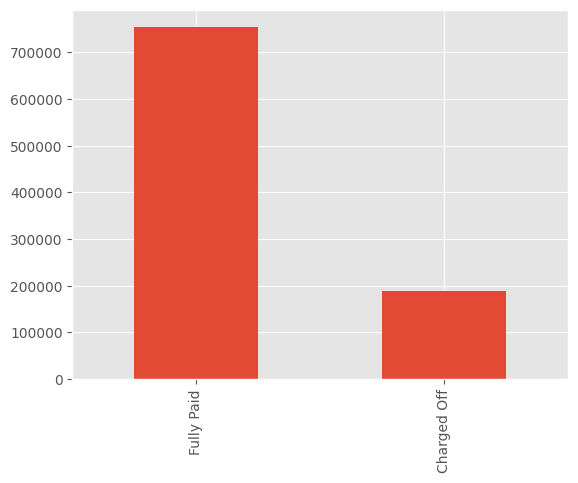

In [415]:
plt.style.use('ggplot')
y_train.value_counts().plot.bar()

## Feature Engineering

In [416]:
# Drop the emp_title column as there are too many unique job titles for one hot encoding
X_train.drop('emp_title', axis=1, inplace=True)
X_test.drop('emp_title', axis=1, inplace=True)
X_train.drop('title', axis=1, inplace=True)
X_test.drop('title', axis=1, inplace=True)
# This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our
# model, so in theory we wouldn't have an issue_date, drop this feature.
X_train.drop('issue_d', axis=1, inplace=True)
X_test.drop('issue_d', axis=1, inplace=True)

In [417]:
# Convert nominal variable to numerical values
print(X_train.emp_length.unique())
X_train['emp_length'].replace(['< 1 year', '1 year','2 years','3 years','4 years','5 years',
'6 years', '7 years', '8 years','9 years','10+ years'], [0,1,2,3,4,5,6,7,8,9,10], inplace=True)
X_test['emp_length'].replace(['< 1 year', '1 year','2 years','3 years','4 years','5 years',
'6 years', '7 years', '8 years','9 years','10+ years'], [0,1,2,3,4,5,6,7,8,9,10], inplace=True)
print(X_train.emp_length.unique())

['10+ years' '1 year' '2 years' '6 years' nan '3 years' '< 1 year'
 '9 years' '8 years' '7 years' '5 years' '4 years']
[10.  1.  2.  6. nan  3.  0.  9.  8.  7.  5.  4.]


In [418]:
# We know that grade is just a sub feature of sub_grade, So we are goinig to drop it.
X_train.drop('grade', axis=1, inplace=True)
X_test.drop('grade', axis=1, inplace=True)
print(X_train.sub_grade.unique())
X_train['sub_grade'].replace(["A1","A2","A3","A4","A5",
                               "B1","B2","B3","B4","B5",
                               "C1","C2","C3","C4","C5",
                               "D1","D2","D3","D4","D5",
                               "E1","E2","E3","E4","E5",
                               "F1","F2","F3","F4","F5",
                               "G1","G2","G3","G4","G5"],

                               [0,1,2,3,4,
                               5,6,7,8,9,
                               10,11,12,13,14,
                               15,16,17,18,19,
                               20,21,22,23,24,
                               25,26,27,28,29,
                               30,31,32,33,34], inplace=True)
X_test['sub_grade'].replace(["A1","A2","A3","A4","A5",
                               "B1","B2","B3","B4","B5",
                               "C1","C2","C3","C4","C5",
                               "D1","D2","D3","D4","D5",
                               "E1","E2","E3","E4","E5",
                               "F1","F2","F3","F4","F5",
                               "G1","G2","G3","G4","G5"],

                               [0,1,2,3,4,
                               5,6,7,8,9,
                               10,11,12,13,14,
                               15,16,17,18,19,
                               20,21,22,23,24,
                               25,26,27,28,29,
                               30,31,32,33,34], inplace=True)
print(X_train.sub_grade.unique())

['D2' 'B5' 'B4' 'C1' 'C5' 'C4' 'F1' 'D1' 'A3' 'B1' 'E1' 'B3' 'G4' 'A4'
 'C2' 'D3' 'C3' 'A2' 'D4' 'A5' 'B2' 'E3' 'E5' 'D5' 'E4' 'E2' 'F5' 'A1'
 'F4' 'G3' 'F3' 'F2' 'G2' 'G5' 'G1']
[16  9  8 10 14 13 25 15  2  5 20  7 33  3 11 17 12  1 18  4  6 22 24 19
 23 21 29  0 28 32 27 26 31 34 30]


### Convert date from format month year to year

In [419]:
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line'])
X_test['earliest_cr_line'] = pd.to_datetime(X_test['earliest_cr_line'])
X_train['earliest_cr_line'] = X_train.earliest_cr_line.dt.year
X_test['earliest_cr_line'] = X_test.earliest_cr_line.dt.year

In [420]:
categorical_col = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_col = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Number of categorical variables:", len(categorical_col))
print("Number of numerical variables:", len(numerical_col))
print("Number of unique values for each categorical variables \n", X_train[categorical_col].nunique())
print("Categorical Variables \n", categorical_col)
print("Numerical Variables \n", numerical_col)

Number of categorical variables: 6
Number of numerical variables: 15
Number of unique values for each categorical variables 
 term                    2
home_ownership          6
verification_status     3
purpose                14
initial_list_status     2
application_type        2
dtype: int64
Categorical Variables 
 ['term', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']
Numerical Variables 
 ['loan_amnt', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


In [421]:
X_train.head().T
# acc_df.describe().T

,37505,1981912,663165,133637,512113
loan_amnt,4000.0,5400.0,12000.0,3500.0,16500.0
term,36 months,36 months,36 months,36 months,36 months
int_rate,16.55,11.49,10.75,12.29,16.02
installment,141.72,178.05,391.45,116.74,580.26
sub_grade,16,9,8,10,14
emp_length,10.0,1.0,1.0,10.0,10.0
home_ownership,MORTGAGE,MORTGAGE,RENT,MORTGAGE,MORTGAGE
annual_inc,57000.0,33280.0,50000.0,72000.0,83000.0
verification_status,Verified,Source Verified,Verified,Verified,Source Verified
purpose,home_improvement,credit_card,debt_consolidation,home_improvement,debt_consolidation


### Drop 0 variance numerical features 

In [422]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_train[numerical_col])
constant_columns = [column for column in X_train[numerical_col].columns
                    if column not in X_train[numerical_col].columns[var_thres.get_support()]]
print(constant_columns)
print(len(constant_columns))
X_train = X_train.drop(constant_columns, axis=1)
X_test = X_test.drop(constant_columns, axis=1)
# Remove the contant_columns from numerical_col
for i in constant_columns:
    numerical_col.remove(i)

[]
0


### Univariate Analysis

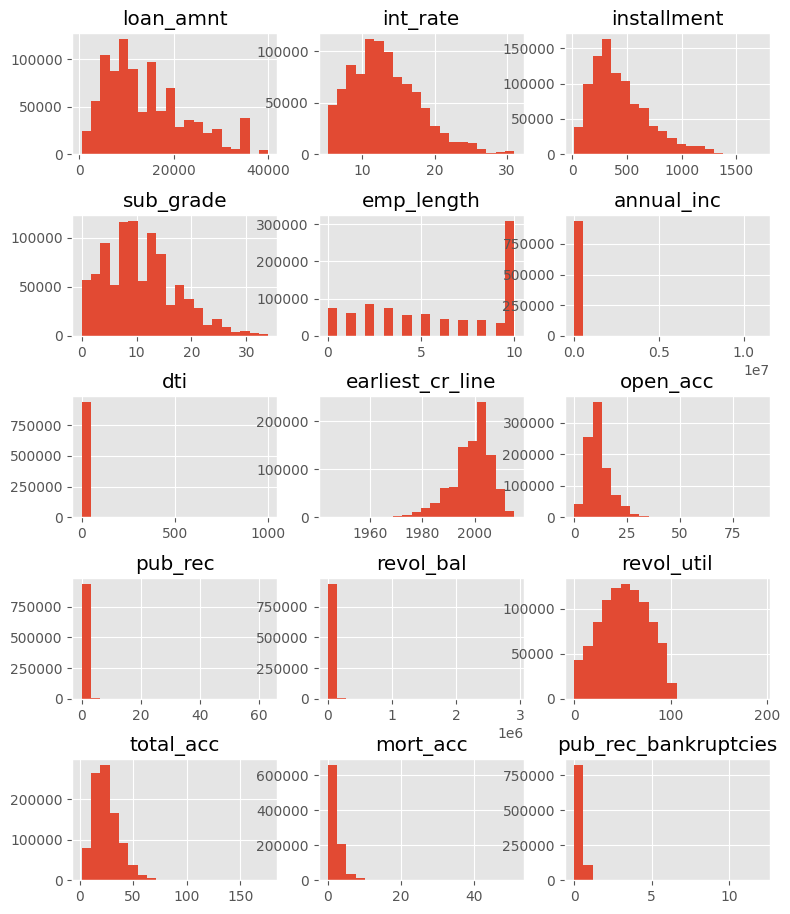

In [423]:
def numerical_plot(X: pd.DataFrame, y=None, numerical_col: List[str]=numerical_col, chart='hist', fig_size=(9, 11)) -> None:
    """Plot for numerical variables

    Args:
        X (pd.DataFrame): independent variables
        y (pd.Series): dependent variables
        chart (str): hist or boxplot
  
    Returns:
        None
    """
    assert isinstance(X, pd.DataFrame)
    plt.figure(figsize=fig_size)
    plt.subplots_adjust(hspace=0.5)
    # set number of columns (use 3 to demonstrate the change)
    ncols = 3
    # calculate number of rows
    nrows = len(numerical_col) // ncols + (len(numerical_col) % ncols > 0)

    # loop through the length of tickers and keep track of index
    for n, numerical_var in enumerate(numerical_col):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)

        # filter df and plot ticker on the new subplot axis
        if chart == 'hist':
            ax.hist(X[numerical_var], bins=20)
        elif chart == "boxplot":
            assert isinstance(y, pd.Series)
            sns.boxplot(x = y, y = X[numerical_var], hue = y)   
        elif chart == "uni_boxplot":
            sns.boxplot(X[numerical_var])   
        else:
            return 0

        # chart formatting
        ax.set_title(numerical_var)
        if ax.get_legend():
            ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")

numerical_plot(X_train, None, chart="hist")


### Multivariate Analysis

#### Correlation Matrix

<AxesSubplot:>

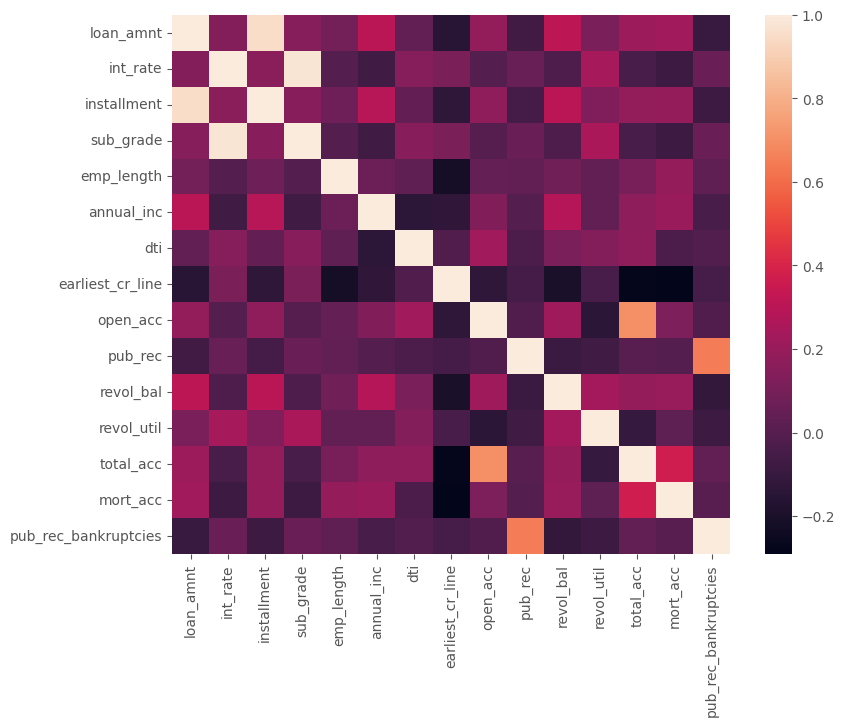

In [424]:
plt.figure(figsize=(9, 7))
sns.heatmap(X_train.corr())

In [425]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    row_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.columns[j]  # getting the name of row
                col_corr.append(colname)
                row_corr.append(rowname)
    return col_corr, row_corr

number of high correlation features: 2
{'sub_grade', 'installment'}


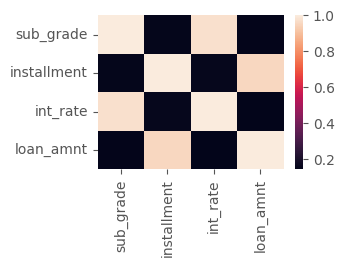

In [426]:
corr_features_col, corr_features_row = correlation(X_train, 0.9)
corr_features_col_set, corr_features_row_set = set(corr_features_col), set(corr_features_row)
print("number of high correlation features:", len(corr_features_col_set))
print(corr_features_col_set)
# Correlation of highly correlated features only
if len(set(corr_features_col))>0:
    plt.figure(figsize=(3, 2))
    sns.heatmap(X_train[corr_features_col_set.union(corr_features_row_set)].corr())

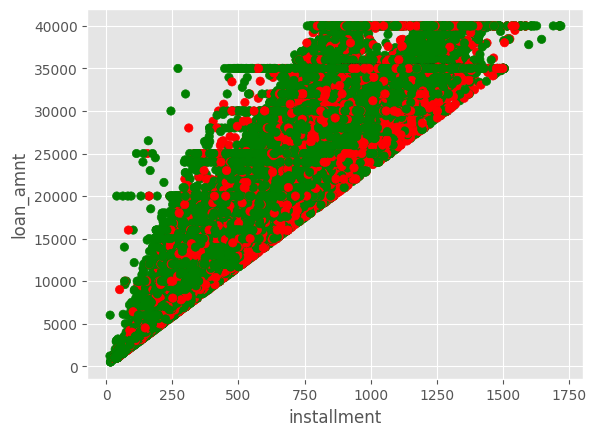

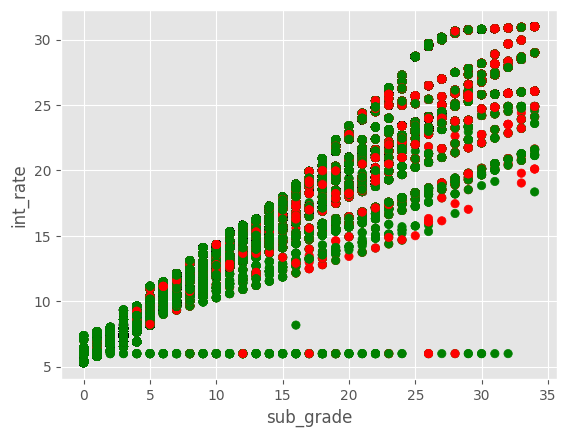

In [427]:
colors = {'Charged Off':'red', 'Fully Paid':'green'}
for i in range(len(corr_features_col)):
    plt.scatter(X_train[corr_features_col[i]], X_train[corr_features_row[i]], c=y_train.map(colors))
    plt.xlabel(corr_features_col[i])
    plt.ylabel(corr_features_row[i])
    plt.show()

#### Bivariate Boxplot

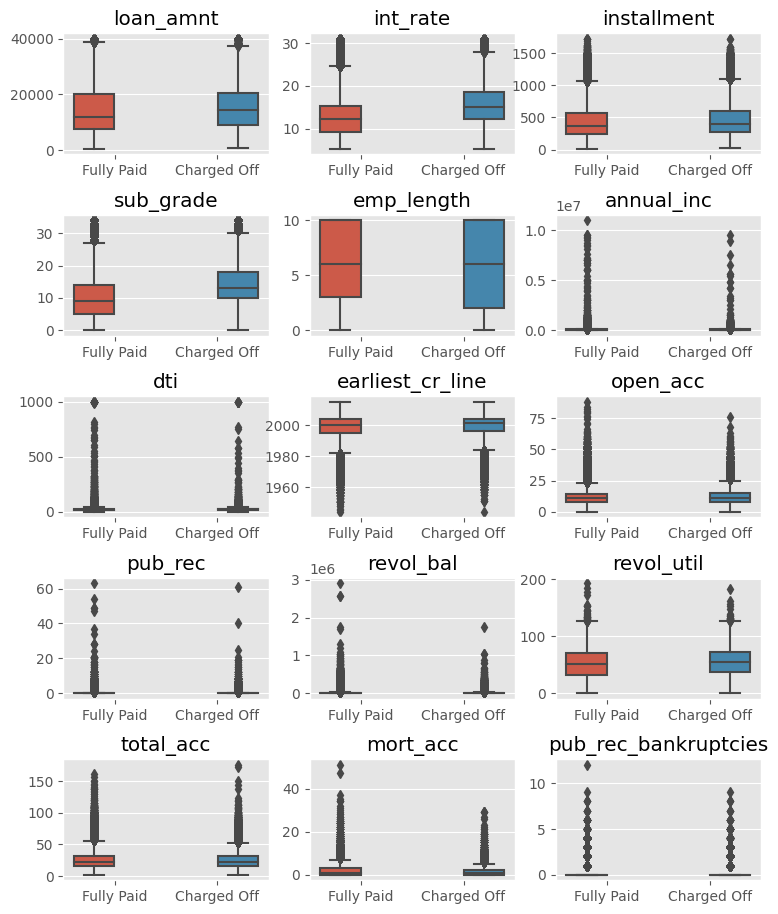

In [428]:
numerical_plot(X_train, y_train, chart="boxplot")

### Handle Outlier

In [429]:
def outlier_perc(values: pd.Series):
    """Calculate the percentage of outlier of the column

    Args:
        values (pd.Series): one of the column of independent variables to be analysed
  
    Returns:
        float: percentage of outlier
    """
    assert isinstance(values, pd.Series)
    Q1, Q3 = np.nanquantile(values, [0.25,0.75])
    IQR = Q3 - Q1
    val_outlier_lower = values[values < (Q1 - 1.5 * IQR)]
    val_outlier_upper = values[values > (Q3 + 1.5 * IQR)]
    val_outlier = pd.concat([val_outlier_lower,val_outlier_upper],axis=1)
    return len(val_outlier)/len(values)

for n, numerical_var in enumerate(numerical_col):
    outlier_percentage = outlier_perc(X_train[numerical_var])
    print(numerical_var, outlier_percentage)

loan_amnt 0.00529776992451023
int_rate 0.018445031787681438
installment 0.03125355069516638
sub_grade 0.0177356891720124
emp_length 0.0
annual_inc 0.04899348742775165
dti 0.004026687423079333
earliest_cr_line 0.03058243612465316
open_acc 0.03415569645657878
pub_rec 0.16961358879578473
revol_bal 0.05920568493507073
revol_util 5.628017759050755e-05
total_acc 0.01678211182340342
mort_acc 0.013340525869236723
pub_rec_bankruptcies 0.12474873024486124


### Handle Categorical Variables

#### Chisquare Test

In [430]:
def chi2test(var1, var2, verbose=False):
    contigency= pd.crosstab(var1, var2) 
    c, p_value, dof, expected = chi2_contingency(contigency)
    return p_value, contigency, expected

In [431]:
X_train = pd.get_dummies(X_train, columns=categorical_col, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_col, drop_first=True)
#get column names that were not in the original dataframe
new_cols = X_train.columns[~X_train.columns.isin(categorical_col+numerical_col)]
for variable in new_cols:
    p_value, contigency, expected = chi2test(X_train[variable], y_train)
    if p_value > 0.05:
        print(variable, p_value)
        # print(contigency)
        # print(expected)

home_ownership_NONE 0.48191397728614027
home_ownership_OTHER 0.8352317374626859
purpose_educational 0.2815466277202549
purpose_vacation 0.14214888156360178


### Handle Missing Values 

#### Drop row with less than 1 percent missing percentage

In [432]:
# df.dropna(subset = ['column_name'])
def dropNaRows(dataX: pd.DataFrame, dataY: pd.Series, null_perc_table: pd.Index,  y_column_names: str, perc_drop=1):
    dataX.insert(0, y_column_names, dataY)
    data = dataX
    for column, null_perc in zip(null_perc_table.index, null_perc_table):
        if null_perc < perc_drop and null_perc > 0:
            data.dropna(subset = [column], inplace=True)
    return data[y_column_names], data.drop(columns=y_column_names)
y_train, X_train = dropNaRows(X_train, y_train, null_perc_table, y_column_names="loan_status")

#### Mice Imputation

In [433]:
# Define MICE Imputer and fill missing values
def impute_normalised_data_with_mice(X_train, X_test, X_train_imputed_name = "X_train_imputed.pkl", X_test_imputed_name = "X_test_imputed.pkl"):
    scaler = MinMaxScaler()
    X_train_normalised = scaler.fit_transform(X_train)
    X_test_normalised = scaler.transform(X_test)
    mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), imputation_order='ascending',  random_state= 42)

    if not os.path.isfile(X_train_imputed_name): 
        X_train_imputed = pd.DataFrame(mice_imputer.fit_transform(X_train_normalised), columns= X_train.columns)
        X_test_imputed = pd.DataFrame(mice_imputer.transform(X_test_normalised), columns= X_test.columns)
        dump(X_train_imputed, X_train_imputed_name)
        dump(X_test_imputed, X_test_imputed_name)
    else:
        X_train_imputed = load(X_train_imputed_name)
        X_test_imputed = load(X_test_imputed_name)
    return X_train_imputed, X_test_imputed
X_train_imputed, X_test_imputed = impute_normalised_data_with_mice(X_train, X_test, X_train_imputed_name = "X_train_imputed.pkl", X_test_imputed_name = "X_test_imputed.pkl")

### Random Forest Model

In [443]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV 
import scipy
import os.path
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

param_grid = {'n_estimators': np.arange(20,100,7),
              'max_features': np.arange(0.1, 1, 0.1),
              'max_depth': scipy.stats.randint(10, 100),
              'max_samples': [0.3, 0.5, 0.8]}

rf_model_name = "rf_model_small.pkl"
if not os.path.isfile(rf_model_name): 
    model = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced_subsample'), param_grid, cv = 3, n_iter = 7, random_state=0, n_jobs=-1).fit(X_train_imputed, y_train) # 165 mins
    dump(model, rf_model_name)
else:
    model = load(rf_model_name)
rf_clf = model.best_estimator_
# rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1) # 3 min 19 s
# rf_clf.fit(X_train_imputed, y_train)

In [444]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [445]:
y_train_pred = rf_clf.predict(X_train_imputed)
y_test_pred = rf_clf.predict(X_test_imputed)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 86.91%
_______________________________________________
CLASSIFICATION REPORT:
             Charged Off     Fully Paid  accuracy      macro avg  \
precision       0.982853       0.860346   0.86906       0.921600   
recall          0.350214       0.998476   0.86906       0.674345   
f1-score        0.516416       0.924279   0.86906       0.720348   
support    187731.000000  752642.000000   0.86906  940373.000000   

            weighted avg  
precision       0.884803  
recall          0.869060  
f1-score        0.842855  
support    940373.000000  
_______________________________________________
Confusion Matrix: 
 [[ 65746 121985]
 [  1147 751495]]

Test Result:
Accuracy Score: 80.14%
_______________________________________________
CLASSIFICATION REPORT:
            Charged Off     Fully Paid  accuracy      macro avg   weighted avg
precision      0.517685       0.809967  0.801409       0.663826       0.751620
recall         0.075936       0.982354  0.80140

In [440]:
y_train_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

### ANN Model

In [374]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
# import tensorflow.keras.backend as K
import tensorflow_addons as tfa

# def get_f1(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

def get_nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5, average="macro")])
    return model

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['f1_score'], label='f1_score')
    plt.plot(r.history['val_f1_score'], label='val_f1_score')
    plt.title('AUC score evolution during trainig')
    plt.legend()

In [392]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

num_columns = X_train_imputed.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 0.001


nn_model = get_nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
class_weight = {0: class_weights[0], 1: class_weights[1]}
nn_model_name = "nn_model"
if not os.path.exists(nn_model_name): 
    r = nn_model.fit(
        np.array(X_train_imputed), y_train,
        validation_data=(np.array(X_test_imputed), y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping], 
        verbose=1,
        class_weight=class_weight
    )
    nn_model.save(nn_model_name)
else:
    nn_model = tf.keras.models.load_model(nn_model_name)

Epoch 1/50
  434/29387 [..............................] - ETA: 2:48 - loss: 0.6962 - f1_score: 0.7066

KeyboardInterrupt: 

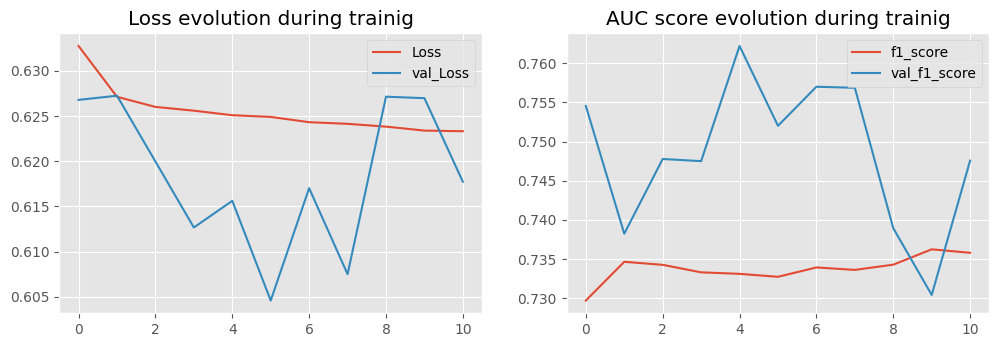

In [131]:
plot_learning_evolution(r)

In [127]:
y_train_pred = nn_model.predict(X_train_imputed)
print_score(y_train, y_train_pred.round(), train=True)
y_test_pred = nn_model.predict(X_test_imputed)
print_score(y_test, y_test_pred.round(), train=False)

29387/29387 [==============================] - 56s 2ms/step
Train Result:
Accuracy Score: 65.16%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.320850       0.886452  0.651574       0.603651   
recall          0.667418       0.647623  0.651574       0.657520   
f1-score        0.433367       0.748446  0.651574       0.590907   
support    187731.000000  752642.000000  0.651574  940373.000000   

            weighted avg  
precision       0.773538  
recall          0.651574  
f1-score        0.685546  
support    940373.000000  
_______________________________________________
Confusion Matrix: 
 [[125295  62436]
 [265214 487428]]

12613/12613 [==============================] - 24s 2ms/step
Test Result:
Accuracy Score: 65.06%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precis

# Remove Outlier

In [446]:
# X_train_imputed, X_test_imputed = impute_normalised_data_with_mice(X_train, X_test, X_train_imputed_name = "X_train_imputed.pkl", X_test_imputed_name = "X_test_imputed.pkl")
boxcox_transform_var_list=["loan_amnt", "int_rate", "installment", "sub_grade"]
for var in boxcox_transform_var_list:
    if var == "sub_grade":
        X_train[var], fitted_lambda = boxcox(X_train[var]+1)
        X_test[var] = boxcox(X_test[var]+1, fitted_lambda)
    else:
        X_train[var], fitted_lambda = boxcox(X_train[var])
        X_test[var] = boxcox(X_test[var], fitted_lambda)

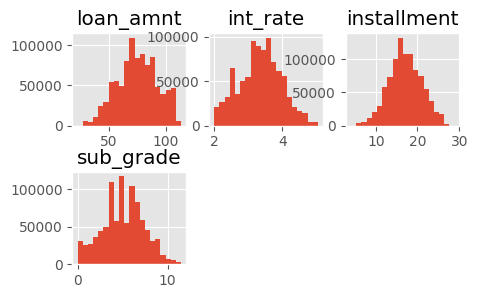

In [447]:
numerical_plot(X_train, None, boxcox_transform_var_list, chart="hist", fig_size=(5, 3))

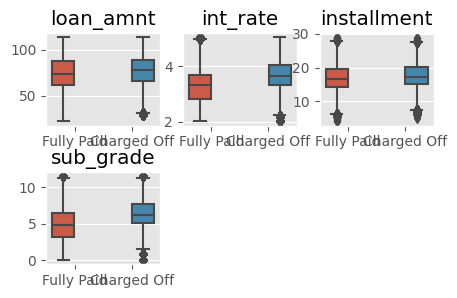

In [448]:
numerical_plot(X_train, y_train, boxcox_transform_var_list, chart="boxplot", fig_size=(5, 3))


In [449]:
def outlier_cap(values: pd.Series, fit=True, lower_limit=None, upper_limit=None):
    """Calculate the percentage of outlier of the column

    Args:
        values (pd.Series): one of the column of independent variables to be analysed
  
    Returns:
        float: percentage of outlier
    """
    assert isinstance(values, pd.Series)
    if fit:
        Q1, Q3 = np.nanquantile(values, [0.25,0.75])
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        return np.where(values > upper_limit, upper_limit,
                            np.where(values < lower_limit, lower_limit,
                            values)), lower_limit, upper_limit
    else:
        return np.where(values > upper_limit, upper_limit,
                            np.where(values < lower_limit, lower_limit,
                            values))

for numerical_var in numerical_col:
    if numerical_var in ['pub_rec', 'pub_rec_bankruptcies']:
        continue
    X_train[numerical_var], lower_limit, upper_limit = outlier_cap(X_train[numerical_var])
    X_test[numerical_var]= outlier_cap(X_test[numerical_var], fit=False, lower_limit=lower_limit, upper_limit=upper_limit)

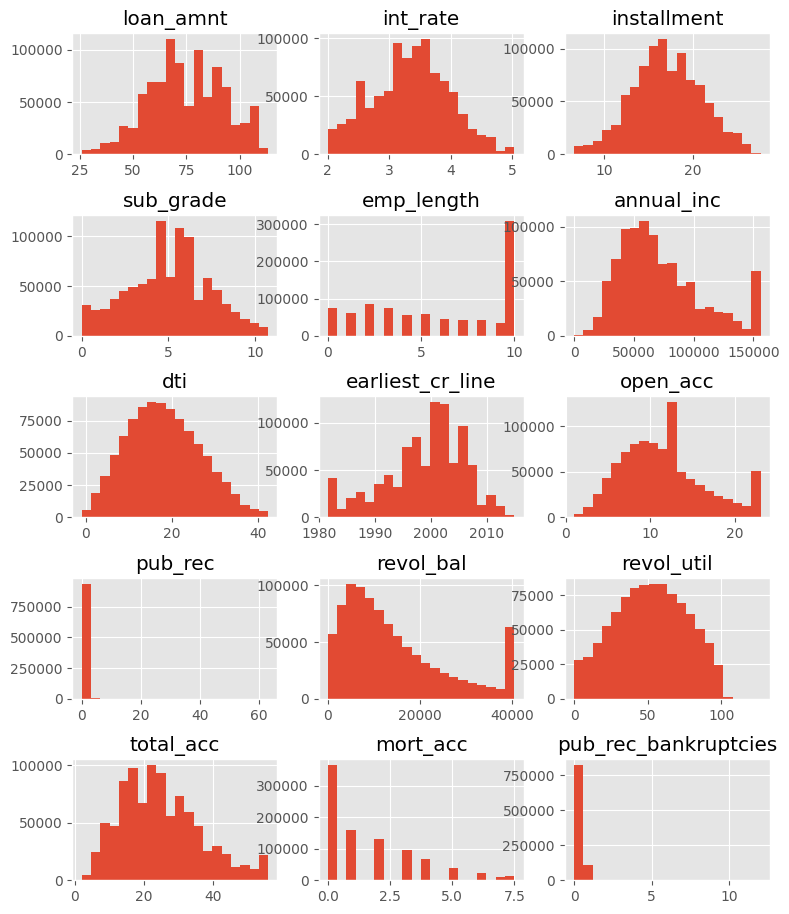

In [450]:
numerical_plot(X_train, None, chart="hist")

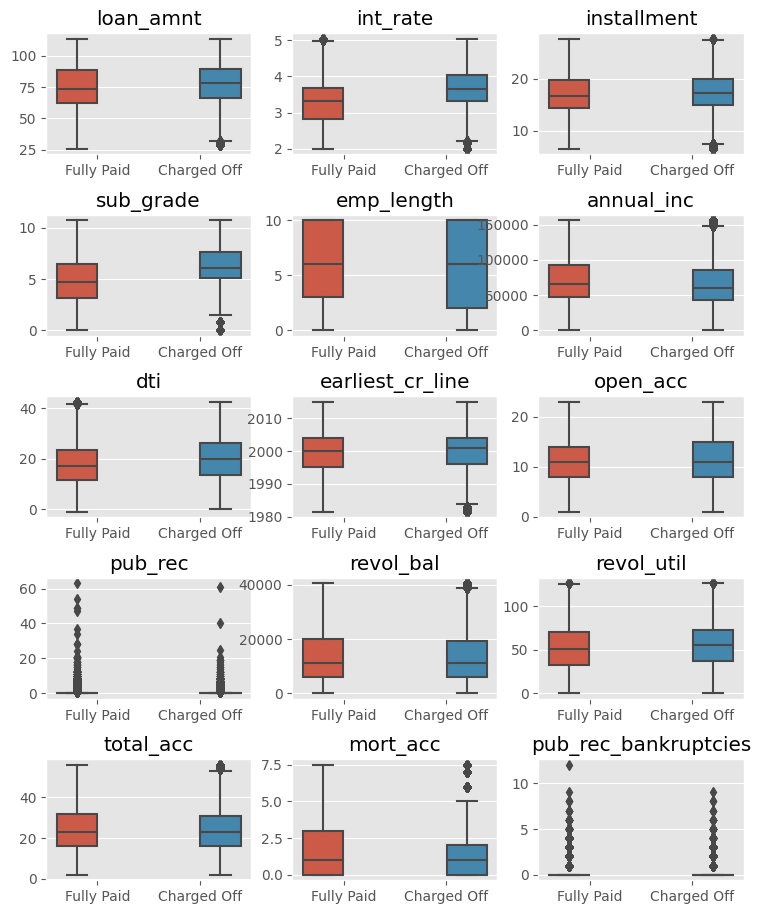

In [451]:
numerical_plot(X_train, y_train, chart="boxplot")

### Bin pub_rec and pub_rec_bankruptcies

#### 83% of pub_rec_bankruptcies is 0 and 88% of pub_rec_bankruptcies is 0 

In [357]:
print(X_train["pub_rec_bankruptcies"].value_counts(normalize=True))
print(X_train["pub_rec"].value_counts(normalize=True))

0.0     0.875113
1.0     0.117406
2.0     0.005848
3.0     0.001159
4.0     0.000311
5.0     0.000102
6.0     0.000040
7.0     0.000011
8.0     0.000007
9.0     0.000002
12.0    0.000001
Name: pub_rec_bankruptcies, dtype: float64
0.0     0.830227
1.0     0.142149
2.0     0.018250
3.0     0.005496
4.0     0.001906
5.0     0.000942
6.0     0.000490
7.0     0.000211
8.0     0.000125
9.0     0.000057
10.0    0.000038
11.0    0.000028
12.0    0.000022
13.0    0.000009
21.0    0.000006
15.0    0.000006
18.0    0.000005
19.0    0.000004
20.0    0.000003
16.0    0.000003
17.0    0.000003
28.0    0.000003
14.0    0.000003
49.0    0.000002
40.0    0.000001
63.0    0.000001
34.0    0.000001
37.0    0.000001
61.0    0.000001
47.0    0.000001
25.0    0.000001
54.0    0.000001
24.0    0.000001
Name: pub_rec, dtype: float64


In [452]:
def bin_0_1(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

X_train["pub_rec_bankruptcies"] = X_train["pub_rec_bankruptcies"].apply(bin_0_1)
X_test["pub_rec_bankruptcies"] = X_test["pub_rec_bankruptcies"].apply(bin_0_1)
X_train["pub_rec"] = X_train["pub_rec"].apply(bin_0_1)
X_test["pub_rec"] = X_test["pub_rec"].apply(bin_0_1)

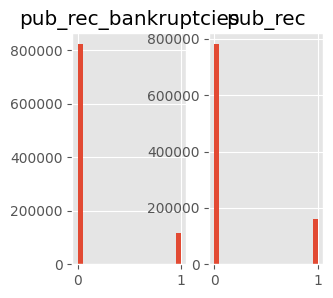

In [361]:
numerical_plot(X_train, None, ["pub_rec_bankruptcies", "pub_rec"], chart="hist", fig_size=(5, 3))

In [453]:
X_train_imputed, X_test_imputed = impute_normalised_data_with_mice(X_train, X_test, 
X_train_imputed_name = "X_train_imputed_preprocessed.pkl", X_test_imputed_name = "X_test_imputed_preprocessed.pkl")

### Random Forest Model

In [456]:
param_grid = {'n_estimators': np.arange(20,100,7),
              'max_features': np.arange(0.1, 1, 0.1),
              'max_depth': scipy.stats.randint(5, 50),
              'max_samples': [0.3, 0.5, 0.8]}

rf_model_name = "rf_model_preprocessed_less_depth.pkl"
if not os.path.isfile(rf_model_name): 
    model = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, cv = 3, n_iter = 7, random_state=0, n_jobs=-1).fit(X_train_imputed, y_train) # 165 mins
    dump(model, rf_model_name)
else:
    model = load(rf_model_name)
rf_clf = model.best_estimator_

In [457]:
y_train_pred = rf_clf.predict(X_train_imputed)
y_test_pred = rf_clf.predict(X_test_imputed)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 86.78%
_______________________________________________
CLASSIFICATION REPORT:
             Charged Off     Fully Paid  accuracy      macro avg  \
precision       0.975252       0.859553  0.867756       0.917402   
recall          0.346357       0.997808  0.867756       0.672083   
f1-score        0.511173       0.923535  0.867756       0.717354   
support    187731.000000  752642.000000  0.867756  940373.000000   

            weighted avg  
precision       0.882650  
recall          0.867756  
f1-score        0.841213  
support    940373.000000  
_______________________________________________
Confusion Matrix: 
 [[ 65022 122709]
 [  1650 750992]]

Test Result:
Accuracy Score: 80.05%
_______________________________________________
CLASSIFICATION REPORT:
            Charged Off     Fully Paid  accuracy      macro avg   weighted avg
precision      0.502349       0.809588  0.800512       0.655968       0.748254
recall         0.074335       0.981633  0.80051

### ANN Model

In [397]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)

num_columns = X_train_imputed.shape[1]
num_labels = 1
hidden_units = [300, 150]
dropout_rates = [0, 0, 0]
learning_rate = 0.001

nn_model = get_nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
class_weight = {0: class_weights[0], 1: class_weights[1]}
nn_model_name = "nn_model_preprocessed_big"
if not os.path.exists(nn_model_name): 
    r = nn_model.fit(
        np.array(X_train_imputed), y_train,
        validation_data=(np.array(X_test_imputed), y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping], 
        verbose=1,
        class_weight=class_weight
    )
    nn_model.save(nn_model_name)
else:
    nn_model = tf.keras.models.load_model(nn_model_name)

Epoch 1/50
29387/29387 [==============================] - 175s 6ms/step - loss: 0.6272 - f1_score: 0.7323 - val_loss: 0.6325 - val_f1_score: 0.7218
Epoch 2/50
29387/29387 [==============================] - 171s 6ms/step - loss: 0.6221 - f1_score: 0.7367 - val_loss: 0.6228 - val_f1_score: 0.7483
Epoch 3/50
29387/29387 [==============================] - 155s 5ms/step - loss: 0.6210 - f1_score: 0.7368 - val_loss: 0.6144 - val_f1_score: 0.7451
Epoch 4/50
29387/29387 [==============================] - 153s 5ms/step - loss: 0.6203 - f1_score: 0.7376 - val_loss: 0.6114 - val_f1_score: 0.7618
Epoch 5/50
29387/29387 [==============================] - 150s 5ms/step - loss: 0.6199 - f1_score: 0.7380 - val_loss: 0.6460 - val_f1_score: 0.7162
Epoch 6/50
29387/29387 [==============================] - 150s 5ms/step - loss: 0.6195 - f1_score: 0.7378 - val_loss: 0.6271 - val_f1_score: 0.7290
Epoch 7/50
29387/29387 [==============================] - 157s 5ms/step - loss: 0.6192 - f1_score: 0.7374 - val_

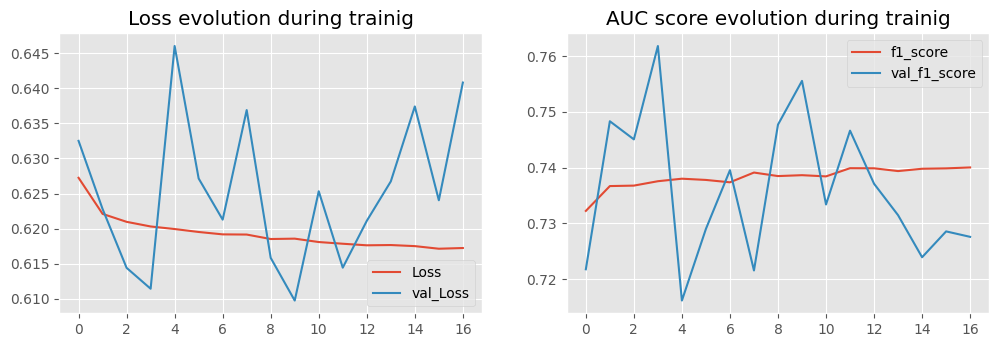

In [398]:
plot_learning_evolution(r)

In [399]:
y_train_pred = nn_model.predict(X_train_imputed)
print_score(y_train, y_train_pred.round(), train=True)
y_test_pred = nn_model.predict(X_test_imputed)
print_score(y_test, y_test_pred.round(), train=False)

29387/29387 [==============================] - 111s 4ms/step
Train Result:
Accuracy Score: 63.37%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.314033       0.893255  0.633695       0.603644   
recall          0.704908       0.615933  0.633695       0.660420   
f1-score        0.434499       0.729114  0.633695       0.581807   
support    187731.000000  752642.000000  0.633695  940373.000000   

            weighted avg  
precision       0.777622  
recall          0.633695  
f1-score        0.670299  
support    940373.000000  
_______________________________________________
Confusion Matrix: 
 [[132333  55398]
 [289065 463577]]

12613/12613 [==============================] - 47s 4ms/step
Test Result:
Accuracy Score: 63.18%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
preci

In [384]:
os.path.exists(nn_model_name)

True